In [1]:
try:
    import imutils 
except:
    !pip install imutils 
    import imutils
    
try: 
    import tensorflow_text
except:
    !pip install tensorflow_text
    import tensorflow_text
    
import os 
import shutil
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import math 
from typing import *
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import models 
from tensorflow.keras import Model
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D,\
                GlobalAveragePooling2D, LayerNormalization, BatchNormalization, ReLU

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=c3355cb81a12a515fe36a29845450529865bfe12a8a8c8ce23e7af2d2d7e4b23
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [28]:
FLICKR_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/"
IMG_DIR_NAME = "flickr30k_images/"
DATAFRAME_NAME = "results.csv"
ROBERTA_PREPROCESSOR_PATH = "https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1"
ROBERTA_ENCODER_PATH ="https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1"
IMG_SHAPE = (128, 128)
BATCH_SIZE = 32
AUTO =  tf.data.AUTOTUNE
ROBERTA_INPUT_FEATURES = ["input_word_ids", "input_type_ids", "input_mask"]
ROBERTA_ENCODER_PATH ="https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1"

In [29]:
df_path = os.path.join(FLICKR_PATH, DATAFRAME_NAME)
img_dir_path = os.path.join(FLICKR_PATH, IMG_DIR_NAME)

In [30]:
flickr_df = pd.read_csv(df_path, delimiter="|")

In [31]:
flickr_df

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [32]:
def create_img_path(df, img_col_name, img_dir_path): 
    """
        this function, will create a new col name image_path, which have a values of the 
            image paths (os.paths) for each respective images.
        Params:
            df(type: pd.DataFrame): Pandas dataframe, which contains flickr data information.
            img_col_name(dtype: str): Image Name column in the dataframe.
            img_dir_path(type: os.Path): Path, where the image data of flickr are presented.
            
        Returns(type: pd.Dataframe)
            returns the pandas dataframe(new dataframe), with adding of new col names (image_path).
    """
    try:
        df_copy = df.copy()
        col = df_copy[img_col_name]

        new_col = img_dir_path + col 
        df_copy['image_path'] = new_col

        df_copy.rename(columns={" comment": "comment"}, inplace=True)
        df_copy.comment = df_copy.comment.astype("str")

        return df_copy
    
    except Exception as err:
        return err

In [33]:
new_flickr_df = create_img_path(flickr_df, 'image_name', img_dir_path)

In [11]:
new_flickr_df

,image_name,comment_number,comment,image_path
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,/kaggle/input/flickr-image-dataset/flickr30k_i...
1,1000092795.jpg,1,"Two young , White males are outside near many...",/kaggle/input/flickr-image-dataset/flickr30k_i...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,/kaggle/input/flickr-image-dataset/flickr30k_i...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,/kaggle/input/flickr-image-dataset/flickr30k_i...
4,1000092795.jpg,4,Two friends enjoy time spent together .,/kaggle/input/flickr-image-dataset/flickr30k_i...
...,...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...,/kaggle/input/flickr-image-dataset/flickr30k_i...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,...",/kaggle/input/flickr-image-dataset/flickr30k_i...
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...,/kaggle/input/flickr-image-dataset/flickr30k_i...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ...",/kaggle/input/flickr-image-dataset/flickr30k_i...


Text one:  Two young guys with shaggy hair look at their hands while hanging out in the yard .
Text two:  A little girl climbing the stairs to her playhouse .


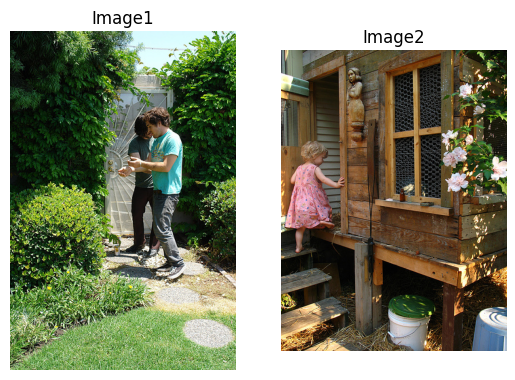

In [12]:
def visualize(df, data_index: List): 
    """
        this function used to visualize the image and the text in the flickr dataframe,
        Params:
            df(type: pandas.DataFrame): Pandas Dataframe, that has a flickr information.
            data_index(type: List): list of two index value, that needed to be visualize.
        Returns(none)
    """
    try: 
        
        image1 = plt.imread(df["image_path"][data_index[0]])
        text1 = df["comment"][data_index[0]]
        
        image2 = plt.imread(df["image_path"][data_index[1]])
        text2 = df["comment"][data_index[1]]

        plt.subplot(1, 2, 1)
        plt.imshow(image1)
        plt.axis("off")
        plt.title("Image1")
        
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
        plt.axis("off")
        plt.title("Image2")

        print(f"Text one: {text1}")
        print(f"Text two: {text2}")

    except Exception as error:
        return error
    
visualize(new_flickr_df, [0, 12])

In [13]:
def build_roberta_preprocessor(preprocessor_path):
    # Reference : https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1
    """Returns Model mapping string features to BERT inputs.

      Args:
        sentence_features: A list with the names of string-valued features.
        seq_length: An integer that defines the sequence length of BERT inputs.

      Returns:
        A Keras Model that can be called on a list or dict of string Tensors
        (with the order or names, resp., given by sentence_features) and
        returns a dict of tensors for input to BERT.
  """
    try:
        text_inputs =[ tf.keras.layers.Input(shape=(), dtype=tf.string)]
      #  preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1")
     #   encoder_inputs = preprocessor(text_input, )
        
        preprocessor = hub.load(preprocessor_path)
        tokenize = hub.KerasLayer(preprocessor.tokenize)
        bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs)

        tokenized_inputs = [tokenize(segment) for segment in text_inputs]
        encoder_inputs = bert_pack_inputs(tokenized_inputs)

        return keras.Model(text_inputs, encoder_inputs)
    
    except Exception as err:
        return err

In [14]:
roberta_preprocessor_model = build_roberta_preprocessor(ROBERTA_PREPROCESSOR_PATH)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [15]:
# testing the roberta preprocessor 

sample = tf.constant(["(your hypothesis text here)"])
preprocessed_txt = roberta_preprocessor_model(sample)
print(f"Text1: {sample}")

print("Keys           : ", list(preprocessed_txt.keys()))
print("Shape Word Ids : ", preprocessed_txt["input_word_ids"].shape)
print("Word Ids       : ", preprocessed_txt["input_word_ids"][0, :16])
print("Shape Mask     : ", preprocessed_txt["input_mask"].shape)
print("Input Mask     : ", preprocessed_txt["input_mask"][0, :16])
print("Shape Type Ids : ", preprocessed_txt["input_type_ids"].shape)
print("Type Ids       : ", preprocessed_txt["input_type_ids"][0, :16])

Text1: [b'(your hypothesis text here)']
Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[    0  1640 16625 31098  2788   259    43     2     1     1     1     1
     1     1     1     1], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [16]:
def dataframe_to_tensor_dataset(dataframe):
    """
        function, will convert the dataframe into the dataset(tf.data.DAtaset) object.
        Params:
            dataframe(type: pandas.DataFrame): Dataframe of the flickr data.
        Return(type: tf.data.Dataset):
            returns the tf.data.Dataset object of the dataframe.
    """
    try:
        columns = ["image_path", "comment"]
        dataframe = dataframe[columns].copy()
        ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
        ds = ds.shuffle(buffer_size=len(dataframe))
        return ds
    
    except Exception as err:
        return err

In [17]:
def get_img(image_path, img_shape):
    """
        tensorflow function, which will read the image from file and convert to tensor, this function will 
            be used by the preprocessing function.
        Params:
            image_pat(type: str): Path of the image(flickr image dir)
            img_shape(type: tuple): image shape for reshaping.
        Return(type: tf.Tensor)
            returns the image tensor, for the given image file.
    """
    try:
        extension = tf.strings.split(image_path)[-1]
        image = tf.io.read_file(image_path)
        if extension == b"jpg":
            image = tf.image.decode_jpeg(image, 3)
        else:
            image = tf.image.decode_png(image, 3)
        image = tf.image.resize(image, img_shape)
        return image
    
    except Exception as err:
        return err

In [18]:
def get_encoder_input(roberta_preprocessor_model, comment):
    """
        this function, will use the roberta preprocessor model, to extract the input
            for the roberta encoder(transform for text).
        Params:
            roberta_preprocessor_model(type: keras.models.Model): roberta preprocessor model for convert the 
                text
            comment(type: str): text value, that needed to converted as a encoder input.
        Return(type: roberta.Input)
            returns the output of the roberta preprocessing model, which is input to the encoder model.
    """
    try:
        comment = tf.convert_to_tensor([comment])
        encoder_inputs = roberta_preprocessor_model(comment)
        return encoder_inputs
    
    except Exception as err:
        return err

In [19]:
def preprocess_data(sample, roberta_preprocessor_model, img_shape):
    """
        this function, will use the get_img and get_encoder_input functions to 
            convert the raw data into useful information.
        Params:
            data(type: tf.Tensc): tensorflow input.
            roberta_preprocessor_model(type: keras.models.Model): roberta preprocessor model for convert the 
                text
            img_shape(type: tuple): image shape for reshaping.
            
        Return(type: Dict):
            returns the dict of preprocessed information.
    """
    try:
        img_path = sample.get("image_path")
        comment = sample.get("comment")

        img = get_img(img_path, img_shape)
        #comment = get_encoder_input(roberta_preprocessor_model, comment)
        
        return {"img": img, "comment": comment}
    
    except Exception as err:
        return err

In [20]:
def prepare_dataset(dataframe, batch_size, auto, training=True):
    """
        this function, will use the preprocess function to convert the raw data into useful data.
        Params:
            dataframe(type: pd.DataFrame): Dataframe, that contains the flickr data.
            batch_size(dtype: Int): Number of batch.
        returns(type; tf.data.Dataset)
            returns teh tensorflow dataset object.
    """
    ds = dataframe_to_tensor_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(dataframe))
    ds = ds.map(lambda x, : (preprocess_data(x, roberta_preprocessor_model, IMG_SHAPE))).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

train_ds = prepare_dataset(new_flickr_df, 16, AUTO)

In [21]:
train_ds

<PrefetchDataset element_spec={'img': TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), 'comment': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>

In [22]:
def project_embeddings(embeddings, num_projection_layers, 
                                projection_dims, dropout_rate):
    """
        this function, will gives the projection embedding for the embeddding of different input,
            eg: (text encoder has different output dims and vision encoder has a diff output dims)
            to make the consistent output dims, we are using projection embedding.
            
        Params:
            embeddings(type: tf.Tensor): output of different encoders.
            num_projection_layers(dtype: Int): number of projection layers need in the projection head.
            dropout_rate(dtype: float): Dropout Rate.
            projection_dims(dtype: int): projection dims.
            
        Return(type: tf.Tensor)
            returns the projection embeddings
    """
    try:
        projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
        for _ in range(num_projection_layers):
            x = tf.nn.gelu(projected_embeddings)
            x = keras.layers.Dense(projection_dims)(x)
            x = keras.layers.Dropout(dropout_rate)(x)
            x = keras.layers.Add()([projected_embeddings, x])
            projected_embeddings = keras.layers.LayerNormalization()(x)
        return projected_embeddings
    
    except Exception as err:
        return err

In [23]:
def create_vision_encoder(num_projection_layers, projection_dims, 
                                          dropout_rate, trainable=False):
    
    """
        this function, will create a vision encoder tensorflow based model, for the image data.
        Params:
            num_projection_layers(dtype: Int): number of projection layers need in the projection head.
                which is used in the projection embedding function.
            dropout_rate(dtype: float): Dropout Rate, which is used in the projection embedding function.
            projection_dims(dtype: int): projection dims, which is used in the projection embedding function.
            
        Return(type: keras.Model)
            returns the keras model for vision encoder.
    """
    try: 
        resnet_v2 = keras.applications.ResNet50V2(
            include_top=False, weights="imagenet", pooling="avg"
        )

        trainable = True

        # Receive the images as inputs.
        image = keras.Input(shape=(128, 128, 3), name="imag")

        preprocessed = keras.applications.resnet_v2.preprocess_input(image)
        embeddings = resnet_v2(preprocessed)

        outputs = project_embeddings(
            embeddings, num_projection_layers, projection_dims, dropout_rate
        )
        
        return keras.Model(image, outputs, name="vision_encoder")
    
    except Exception as err:
        return err

In [24]:
def create_text_encoder(roberta_encoder_path, bert_input_features, 
                                num_projection_layers, projection_dims, dropout_rate, trainable=False):
    """
        this function, will create text encoder of the type tensorflow. which is used for the 
            textual data.
        Params:
            roberta_encoder_path(dtype: str): roberta encoder path, which is tensorflow hub path for loading
                the model.
            bert_input_features(dtype: List): List of roberta feature names.
            num_projection_layers(dtype: Int): number of projection layers need in the projection head.
                which is used in the projection embedding function.
            dropout_rate(dtype: float): Dropout Rate, which is used in the projection embedding function.
            projection_dims(dtype: int): projection dims, which is used in the projection embedding function.
            
        Return(type: keras.Model)
            returns the keras model for vision encoder.
    """
    try: 
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
        preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1")
        encoder_inputs = preprocessor(text_input)

        encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1", trainable=True)
        encoder_outputs = encoder(encoder_inputs)
        embeddings = encoder_outputs["pooled_output"]      # [batch_size, 768].
        outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
        model = tf.keras.Model(text_input, outputs)
        return model

    except Exception as err:
        return err

In [25]:
def create_clip_model(roberta_encoder_path, img_input_dims, bert_input_features, num_projection_layers, 
                                    projection_dims, dropout_rate, vision_trainable, text_trainable):
    """
        this function will create the CLIP(Contrastive Language Image Pretrained) model,by 
            inclusing the vision encoder and text encoder.
        Params:
            roberta_encoder_path(dtype: str): roberta encoder path, which is tensorflow hub path for loading
                the model.
            bert_input_features(dtype: List): List of roberta feature names.
            num_projection_layers(dtype: Int): number of projection layers need in the projection head.
                which is used in the projection embedding function.
            dropout_rate(dtype: float): Dropout Rate, which is used in the projection embedding function.
            projection_dims(dtype: int): projection dims, which is used in the projection embedding function.
        Returns(type: keras.Model)
            returns the CLIP keras model.
    """
    image = keras.Input(shape=img_input_dims, name="image")

    text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)

    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        roberta_encoder_path, bert_input_features, num_projection_layers, projection_dims, dropout_rate, text_trainable
    )
        
    vision_projections = vision_encoder(image)
    text_projections = text_encoder(text_inputs)
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)

    return keras.Model([image, text_inputs], [vision_projections, text_projections])

In [26]:
temperature = tf.Variable(tf.constant(1.0, dtype=tf.float32))
def contrastive_loss(logits) :
    return tf.math.reduce_mean(
        tf.keras.metrics.sparse_categorical_crossentropy(
            y_true=tf.range(logits.shape[0]), y_pred=logits, from_logits=True
        )
    )

def clip_loss(text_embeds, image_embeds, logit_scale) :
    # normalized features
    image_embeds = image_embeds / tf.norm(tensor=image_embeds, ord="euclidean", axis=-1, keepdims=True)
    text_embeds = text_embeds / tf.norm(tensor=text_embeds, ord="euclidean", axis=-1, keepdims=True)

    # cosine similarity as logits
    logit_scale = tf.math.exp(logit_scale)
    logits_per_text = tf.matmul(text_embeds, image_embeds, transpose_b=True) * logit_scale
    logits_per_image = tf.transpose(logits_per_text)
    similarity = logits_per_text

    caption_loss = contrastive_loss(similarity)
    image_loss = contrastive_loss(tf.transpose(similarity))
    return (caption_loss + image_loss) / 2.0

# https://github.com/lucidrains/x-clip
def lucidrains_loss(text_latents, image_latents, temperature):
    # equal to clip_loss
    num_batch_texts = num_batch_images = 1
    text_latents, image_latents = map(l2norm, (text_latents, image_latents))

    # get temperature
    temp = tf.exp(temperature)

    # split out multiview dimension for text and images
    text_latents = rearrange(text_latents, '(m b) ... -> m b ...', m=num_batch_texts)
    image_latents = rearrange(image_latents, '(m b) ... -> m b ...', m=num_batch_images)

    # calculate loss
    text_to_image = einsum('m t d, n i d -> m n t i', text_latents, image_latents) * temp
    image_to_text = rearrange(text_to_image, '... t i -> ... i t')

    text_to_image = rearrange(text_to_image, 'm n ... -> (m n) ...')
    image_to_text = rearrange(image_to_text, 'm n ... -> (m n) ...')

    # exponentiate
    text_to_image_exp, image_to_text_exp = map(tf.exp, (text_to_image, image_to_text))

    # numerators
    text_to_image_pos, image_to_text_pos = map(matrix_diag, (text_to_image_exp, image_to_text_exp))

    # denominator
    text_to_image_denom, image_to_text_denom = map(lambda t: tf.reduce_sum(t, axis=-1),
                                                   (text_to_image_exp, image_to_text_exp))

    # loss
    text_to_image_loss = tf.reduce_mean(-log(text_to_image_pos / text_to_image_denom), axis=-1)
    image_to_text_loss = tf.reduce_mean(-log(image_to_text_pos / image_to_text_denom), axis=-1)

    # calculate CL loss
    cl_loss = (text_to_image_loss + image_to_text_loss) / 2

    return cl_los

def train_step(inputs, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:

        text_input, img_input = inputs.get("comment"), inputs.get("img")
        image_embeddings, text_embeddings = model([img_input, text_input], training=True)

        loss_value = clip_loss(text_embeddings, image_embeddings, temperature)
        
    model_params = model.trainable_weights
    grads = tape.gradient(loss_value, model_params)
    optimizer.apply_gradients(zip(grads, model_params))
    del tape

    return loss_value

def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [27]:
def manual_train(train_dataset,
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=3, 
          log_step=200, 
          val_log_step=50):
  
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = 0
        val_loss = []

        for step, training_batch in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
            if step == 1000:
                break
            loss_value = train_step(training_batch, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss += float(loss_value)

        print(f"Training loss over epoch: {train_loss/len(train_dataset)}")
        model.save(f"clip-{epoch}-epochs.h5")
    return model
    

In [28]:
IMG_INPUT_SHAPE = (128, 128, 3)
clip_model = create_clip_model(ROBERTA_ENCODER_PATH, IMG_INPUT_SHAPE, ROBERTA_INPUT_FEATURES, 1, 256, 0.2, False, False)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


<keras.engine.functional.Functional object at 0x7c652307e800> <keras.engine.functional.Functional object at 0x7c61254fdf60>


In [29]:
import tqdm
trained_model = manual_train(train_ds, clip_model, keras.optimizers.Adam(), None, None, None, epochs=3)


Start of epoch 0


 10%|█         | 1000/9933 [18:19<2:43:40,  1.10s/it]


Training loss over epoch: 0.2795906027290116

Start of epoch 1


 10%|█         | 1000/9933 [17:11<2:33:32,  1.03s/it]


Training loss over epoch: 0.27934319802812974

Start of epoch 2


 10%|█         | 1000/9933 [17:09<2:33:19,  1.03s/it]


Training loss over epoch: 0.2792395204860711


In [31]:
trained_model.save("clip_full.h5")